In [1]:

import os
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
import scipy.spatial.distance as dist
import catboost as cbt
import json
from sklearn.metrics import f1_score
import time

import gc
import math
from tqdm import tqdm
from scipy import stats
from sklearn.cluster import KMeans
from six.moves import reduce
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import matplotlib.pyplot as plt
from datetime import datetime,timedelta

In [2]:
os.listdir(r'H:\compitition\sichuan-fusai\cbt')
submission = pd.read_csv(r'H:\compitition\sichuan\cbt\submit_example.csv')
train = pd.read_csv(r'H:\compitition\sichuan-fusai\cbt/train8162.csv')
test = pd.read_csv(r'H:\compitition\sichuan-fusai\cbt/test8162.csv')

In [3]:
data = train.append(test)

In [4]:
data.shape

(3163, 114)

In [5]:
cat_list = [i for i in train.columns if i in ['city_name','county_name','idcard_cnt'
]]
for i in tqdm(cat_list):
    data['{}_count'.format(i)] = data.groupby(['{}'.format(i)])['ID'].transform('count')
feature_name = [i for i in data.columns if i not in ['ID','Label']]

100%|███████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 299.94it/s]


In [6]:
tr_index = ~data['Label'].isnull()
X_train = data[tr_index][list(set(feature_name))].reset_index(drop=True)
y = data[tr_index]['Label'].reset_index(drop=True).astype(int)
X_test = data[~tr_index][list(set(feature_name))].reset_index(drop=True)
print(X_train.shape,X_test.shape)
oof = np.zeros(X_train.shape[0])
prediction = np.zeros(X_test.shape[0])
seeds = [19970412, 2019 * 2 + 1024, 4096, 2018, 1024]
num_model_seed = 5
for model_seed in range(num_model_seed):
    oof_cat = np.zeros(X_train.shape[0])
    prediction_cat=np.zeros(X_test.shape[0])
    skf = StratifiedKFold(n_splits=5, random_state=seeds[model_seed], shuffle=True)
    for index, (train_index, test_index) in enumerate(skf.split(X_train, y)):
        print(index)
        train_x, test_x, train_y, test_y = X_train[feature_name].iloc[train_index], X_train[feature_name].iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        cbt_model = cbt.CatBoostClassifier(iterations=8000,learning_rate=0.08,max_depth=8,verbose=100,
                                       early_stopping_rounds=500,task_type='GPU',eval_metric='AUC',
                                       cat_features=cat_list)
        cbt_model.fit(train_x[feature_name], train_y,eval_set=(test_x[feature_name],test_y))
        gc.collect()    
        oof_cat[test_index] += cbt_model.predict_proba(test_x)[:,1]
        prediction_cat += cbt_model.predict_proba(X_test[feature_name])[:,1]/5   
    oof += oof_cat / num_model_seed
    prediction += prediction_cat / num_model_seed
print('score',f1_score(y, np.round(oof)))    

(1845, 115) (1318, 115)
0
0:	learn: 0.8939280	test: 0.8508427	best: 0.8508427 (0)	total: 132ms	remaining: 17m 33s
100:	learn: 0.9999813	test: 0.9581640	best: 0.9583333 (97)	total: 11.4s	remaining: 14m 50s
200:	learn: 1.0000000	test: 0.9547764	best: 0.9583333 (97)	total: 22.9s	remaining: 14m 47s
300:	learn: 1.0000000	test: 0.9558350	best: 0.9583333 (97)	total: 34.4s	remaining: 14m 39s
400:	learn: 1.0000000	test: 0.9553692	best: 0.9583333 (97)	total: 46.1s	remaining: 14m 33s
500:	learn: 1.0000000	test: 0.9560468	best: 0.9583333 (97)	total: 57.8s	remaining: 14m 25s
bestTest = 0.9583333135
bestIteration = 97
Shrink model to first 98 iterations.
1
0:	learn: 0.9010734	test: 0.8895003	best: 0.8895003 (0)	total: 112ms	remaining: 14m 51s
100:	learn: 0.9999734	test: 0.9807513	best: 0.9813461 (86)	total: 11.6s	remaining: 15m 8s
200:	learn: 1.0000000	test: 0.9818560	best: 0.9818560 (200)	total: 23.3s	remaining: 15m 5s
300:	learn: 1.0000000	test: 0.9830458	best: 0.9830458 (300)	total: 35.2s	remaini

200:	learn: 1.0000000	test: 0.9704683	best: 0.9719555 (59)	total: 23.8s	remaining: 15m 24s
300:	learn: 1.0000000	test: 0.9711906	best: 0.9719555 (59)	total: 35.7s	remaining: 15m 12s
400:	learn: 1.0000000	test: 0.9706382	best: 0.9719555 (59)	total: 47.4s	remaining: 14m 58s
500:	learn: 1.0000000	test: 0.9706807	best: 0.9719555 (59)	total: 59.1s	remaining: 14m 45s
bestTest = 0.9719554782
bestIteration = 59
Shrink model to first 60 iterations.
3
0:	learn: 0.8714425	test: 0.8031784	best: 0.8031784 (0)	total: 112ms	remaining: 14m 52s
100:	learn: 0.9999787	test: 0.9657941	best: 0.9657941 (100)	total: 11.8s	remaining: 15m 20s
200:	learn: 1.0000000	test: 0.9677488	best: 0.9684287 (185)	total: 23.6s	remaining: 15m 13s
300:	learn: 1.0000000	test: 0.9656667	best: 0.9684287 (185)	total: 35.5s	remaining: 15m 8s
400:	learn: 1.0000000	test: 0.9650293	best: 0.9684287 (185)	total: 47.4s	remaining: 14m 58s
500:	learn: 1.0000000	test: 0.9639245	best: 0.9684287 (185)	total: 59.3s	remaining: 14m 47s
600:	le

bestTest = 0.9695334435
bestIteration = 473
Shrink model to first 474 iterations.
2
0:	learn: 0.8911006	test: 0.8681270	best: 0.8681270 (0)	total: 114ms	remaining: 15m 14s
100:	learn: 0.9999707	test: 0.9735702	best: 0.9736552 (88)	total: 11.7s	remaining: 15m 16s
200:	learn: 1.0000000	test: 0.9766296	best: 0.9769270 (199)	total: 23.4s	remaining: 15m 7s
300:	learn: 1.0000000	test: 0.9767146	best: 0.9772245 (256)	total: 35.1s	remaining: 14m 59s
400:	learn: 1.0000000	test: 0.9765871	best: 0.9774369 (321)	total: 46.9s	remaining: 14m 49s
500:	learn: 1.0000000	test: 0.9766721	best: 0.9774369 (321)	total: 58.8s	remaining: 14m 40s
600:	learn: 1.0000000	test: 0.9764596	best: 0.9774369 (321)	total: 1m 10s	remaining: 14m 30s
700:	learn: 1.0000000	test: 0.9762896	best: 0.9774369 (321)	total: 1m 22s	remaining: 14m 20s
800:	learn: 1.0000000	test: 0.9759072	best: 0.9774369 (321)	total: 1m 34s	remaining: 14m 8s
bestTest = 0.9774369001
bestIteration = 321
Shrink model to first 322 iterations.
3
0:	learn

In [7]:
submit = test[['ID']]
submit['label'] = prediction

submit.to_csv("submission916.csv",index=False)

D:\A\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
submit = test[['ID']]
submit['label'] = (prediction>=0.52).astype(int)  #以0.5为界
submit['label'].replace(0,'FALSE',inplace = True)
submit['label'].replace(1,'True',inplace = True)
submit.rename(columns={'ID':'phone_no_m'})
print(submit['label'].value_counts())
submit.to_csv("submission0843.csv",index=False)

D:\A\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\A\lib\site-packages\pandas\core\generic.py:6786: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


FALSE    1065
True      253
Name: label, dtype: int64


<BarContainer object of 115 artists>

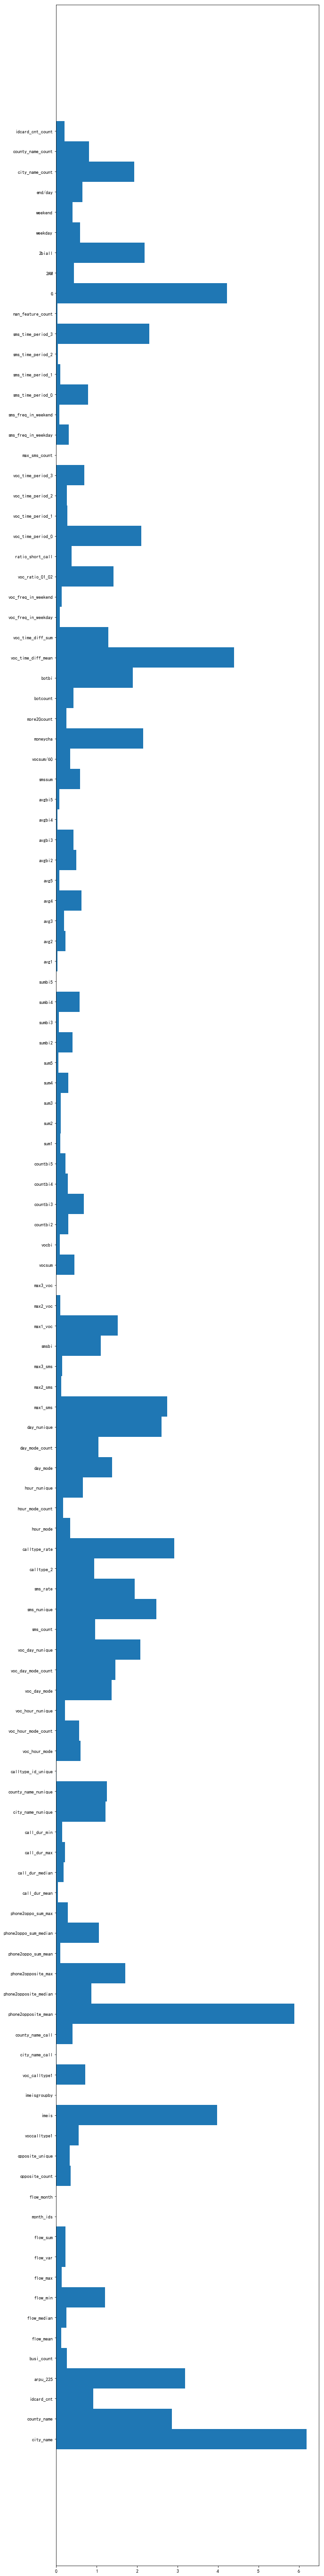

In [9]:
import matplotlib.pyplot as plt 


plt.rcParams['font.sans-serif'] = ['KaiTi'] # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题

fea_ = cbt_model.feature_importances_
fea_name = cbt_model.feature_names_
plt.figure(figsize=(10, 100))
plt.barh(fea_name,fea_,height =1)

In [12]:

submission['Label'] = prediction

submission.to_csv("submission0416cat.csv",index=False)